In [ ]:
!pip install transformers


In [ ]:
#install hugging face evaluate 
!pip install evaluate

In [4]:
# imports 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 

import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import pipeline

#from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login
from textwrap import wrap


import evaluate


from sklearn.metrics import confusion_matrix, classification_report  


In [5]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')
     

Mounted at /content/drive


In [6]:
# Data

# French trainset/valset 
fr_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /train_french.csv") 
fr_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /val_french.csv") 

# Dutch trainset/valset 

##nl_trainset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /train_dutch.csv") 
##nl_valset= pd.read_csv("/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /val_dutch.csv") 

In [ ]:
fr_trainset

,messages_fr,label
0,"['Hey, que se passe-t-il?', ' hey', 'Comment ç...",1
1,"['Asl', 'Je suis un homme de 18 ans, cherchant...",0
2,"['Bonjour', 'Hi owo', 'Je dois faire des poupé...",0
3,"['Bonjour', ""j'obtiens toujours ceci: release\...",0
4,"['Bonjour', 'Hey there (en anglais seulement)'...",0
...,...,...
5265,"['Bonjour', ""besoin d'un outil pour migrer les...",0
5266,"[""Qu'est-ce que tu fais beau?"", 'rechercher de...",1
5267,"['ANNEXE', 'Asl', 'Hey :D', 'haha omg.. quicky...",0
5268,"[""C'est un peu comme ça, c'est un peu comme ça...",0


In [7]:
#French test set 
fr_testset= pd.read_csv('/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /test_french.csv')

#Dutch test set 
#nl_testset=pd.read_csv('/content/drive/MyDrive/IM/VTPAN_PAN12_Translated /test_dutch.csv')

In [ ]:
fr_testset

,id,isCybergrooming,authors,messages,messages_de,label
0,de15188e9fd515ed817a0b34546be902,True,"[{'id': 'b6fe182274453b707870b16e5d2ad562', 'i...",[{'author': 'b6fe182274453b707870b16e5d2ad562'...,"[""de l'arrière"", 'ok baby', ""ce qui s'est pass...",1
1,17784c5a093477c1706b1a68cea7c802,False,"[{'id': 'fcfda042c76436b97eca32b6c0490d1d', 'i...",[{'author': '713349f3afa2dbe352d2abe4d3f01a12'...,"['Bonjour', 'Les garçons sont de la mer', 'qu’...",0
2,15a38614944f5aa8bbb59d4153ecc12a,False,"[{'id': '454addae11c0b90c0f36a98b77aa07a6', 'i...",[{'author': 'ee792e8acb278ddd16cc46020c694b0b'...,"['Bonjour', '19 m usa horny, u?', '2+2*2', '2+...",0
3,ee0aba2365c16a30cb36d1057a390b16,False,"[{'id': '471970f323f46dc39b5f07c6aa344686', 'i...",[{'author': 'bb2a120ae4ec93ef7c15f284b9b46544'...,"['f/m?', 'Bonjour', 'de l’eau', 'f) Évaluation...",0
4,ca1b963746e368a4cec38ab4be3fdcf7,False,"[{'id': 'ed6658e6f22583ed66fb5e5e735b9e63', 'i...",[{'author': 'ed6658e6f22583ed66fb5e5e735b9e63'...,"['Merci, je suis maintenant de retour.', 'Je v...",0
...,...,...,...,...,...,...
15324,85e044706ceca109b1adf6c744a4126c,False,"[{'id': 'f8eb7d3ae7f27896e571109636a043e0', 'i...",[{'author': 'f8eb7d3ae7f27896e571109636a043e0'...,"['J’aimerais vous remercier', 'Bonjour', 'Hey....",0
15325,ec391a65097a955029afaedc23d5fa81,True,"[{'id': '2e0d170f2addfb0048f9424a2daa5a73', 'i...",[{'author': '2e0d170f2addfb0048f9424a2daa5a73'...,"['Bonjour', 'Asl?', 'Heya, que se passe-t-il?'...",1
15326,82add2c9da3c267a98b3981375b6c238,True,"[{'id': 'c5502c7c9bb5e28508a3e19ec869f6d2', 'i...",[{'author': 'c5502c7c9bb5e28508a3e19ec869f6d2'...,"['Bonjour, comment est-ce?', ""J'aimerais vous ...",1
15327,e2bc24141a2855dd6825d8b3132bfa11,False,"[{'id': 'e46825dc4ec1ff89f6bb078ce5589357', 'i...",[{'author': 'bced152c52f046adc88110ad1e8b3e83'...,"['Bonjour', 'm ou f', 'Bonjour', 'f) Évaluatio...",0


# **Model**

In [ ]:
#load model 
model= AutoModelForSequenceClassification.from_pretrained("xlm-roberta-base")

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

In [9]:
#data to list
X_train = list(fr_trainset["messages_fr"])
y_train = list(fr_trainset["label"])
X_val = list(fr_valset["messages_fr"])
y_val = list(fr_valset["label"])
   

In [10]:
#French testset
X_test_fr = list(fr_testset["messages_de"])
y_test_fr = list(fr_testset["label"])

#Dutch testset 
##X_test_nl = list(nl_testset["messages_de"])
##y_test_nl = list(nl_testset["label"])

In [11]:
#tokenize train/val data 
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)


In [12]:
#tokenize test data

test_encodings_fr = tokenizer(X_test_fr, truncation=True, padding=True, max_length=512)
#test_encodings_nl = tokenizer(X_test_nl, truncation=True, padding=True, max_length=512)

In [13]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
     

In [14]:
#load the 3 datase
train_dataset = Dataset(train_encodings, y_train)
val_dataset = Dataset(val_encodings, y_val)

#test_dataset_eng = Dataset(test_encodings_eng, y_test_eng)
test_dataset_fr = Dataset(test_encodings_fr, y_test_fr)


# **Model training on German**

In [15]:
# Define Trainer
args = TrainingArguments(
    output_dir="xmlRoberta_Fr",
    num_train_epochs=3,
    per_device_train_batch_size=16

)
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=val_dataset)

In [16]:
#train
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.262100


TrainOutput(global_step=990, training_loss=0.18666982939749052, metrics={'train_runtime': 1651.0585, 'train_samples_per_second': 9.576, 'train_steps_per_second': 0.6, 'total_flos': 4159785785241600.0, 'train_loss': 0.18666982939749052, 'epoch': 3.0})

In [ ]:
notebook_login()


Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
#push model to hub
trainer.push_to_hub()

# **Test XML-Roberta on French test data**

In [17]:
#get prediction from French test data 
predictions = trainer.predict(test_dataset_fr)
preds_fr = np.argmax(predictions.predictions, axis=-1)
     

In [18]:
# macro f1 on test French data 
metric = evaluate.load("f1")
metric.compute(predictions=preds_fr, references=y_test_fr,  average="macro")
     

{'f1': 0.9491182144851288}

In [19]:
class_names = [ 'non predator', 'predator']
     

In [20]:
#classification report

print(classification_report(y_test_fr, preds_fr, target_names=class_names))

              precision    recall  f1-score   support

non predator       1.00      0.98      0.99     13863
    predator       0.86      0.96      0.91      1466

    accuracy                           0.98     15329
   macro avg       0.93      0.97      0.95     15329
weighted avg       0.98      0.98      0.98     15329



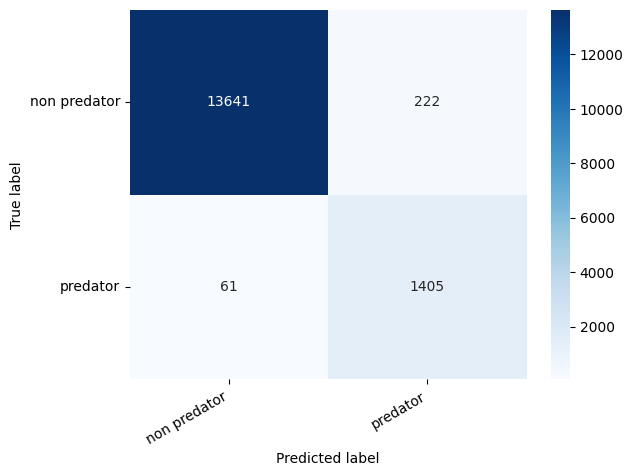

In [21]:
#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test_fr, preds_fr)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)
     

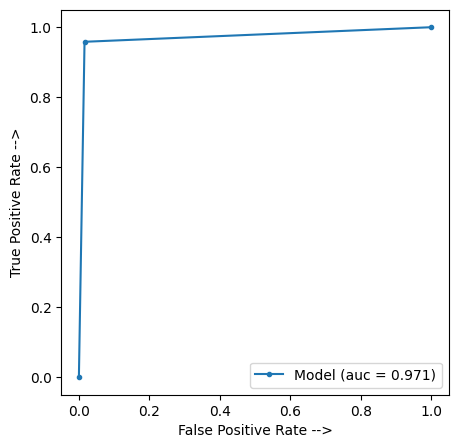

In [22]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, threshold = roc_curve(y_test_fr, preds_fr)
auc = auc(fpr, tpr)

#svm_fpr, svm_tpr, threshold = roc_curve(y_test, y_pred_svm)
#auc_svm = auc(svm_fpr, svm_tpr)

plt.figure(figsize=(5, 5), dpi=100)
#plt.plot(svm_fpr, svm_tpr, linestyle='-', label='SVM (auc = %0.3f)' % auc_svm)
plt.plot(fpr, tpr, marker='.', label='Model (auc = %0.3f)' % auc)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [23]:
#missclassified examples 
misclassified = np.where(preds_fr != y_test_fr)
print(misclassified)

(array([   41,    75,    85,   157,   211,   284,   287,   342,   365,
         435,   465,   723,   729,   734,   863,   886,   929,  1051,
        1052,  1074,  1104,  1115,  1157,  1180,  1203,  1205,  1259,
        1285,  1374,  1501,  1514,  1524,  1557,  1576,  1600,  1609,
        1723,  1744,  1781,  1783,  1827,  1958,  2021,  2076,  2087,
        2221,  2298,  2312,  2366,  2389,  2454,  2551,  2563,  2576,
        2683,  2732,  2752,  2757,  2793,  2816,  2821,  2835,  2853,
        2873,  2944,  3118,  3222,  3266,  3276,  3340,  3428,  3434,
        3779,  3861,  3959,  4063,  4127,  4244,  4304,  4402,  4455,
        4483,  4515,  4660,  4677,  4884,  4971,  5035,  5043,  5062,
        5200,  5201,  5264,  5321,  5346,  5352,  5371,  5383,  5429,
        5434,  5535,  5568,  5633,  5666,  5677,  5697,  5748,  5762,
        5767,  5892,  5902,  5910,  5928,  5956,  6027,  6054,  6173,
        6236,  6289,  6356,  6372,  6459,  6502,  6599,  6632,  6714,
        6850,  6938

In [25]:
#example from the test data and its true and predicted labels
idx = 1827
review_text = fr_testset['messages_de'][idx]
true_sentiment = y_test_fr[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds_fr[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds_fr[idx]}')


['Asl', '13 f sud du portland u?', 'Bonjour', 'comme les plus âgés?',
'sable oui', '21m', 'refroidissement', "Il n'y a pas d'autre chose à
faire.", 'sur mon métier', "j'ai 1", 'très joli', 'État de
répartition', 'Oui', 'TÉLÉCOPIEUR', 'u a une photo', 'Ya (en anglais
seulement)', 'connectez-vous avec moi', 'huh', 'Cliquez sur le bouton
qui affiche les photos', 'en haut de la page', 'Il ne fonctionnera
pas', 'envoyer par e-mail', 'quelle est votre adresse électronique',
'L’objectif est d’améliorer la qualité de vie des Canadiens et des
Canadiennes et d’améliorer l’accès à l’information.', 'k h/o', 'kk',
'envoi', 'kk', "je l'ai retenue", 'omg ur cute', 'de l’eau potable',
'où vous habitez', 'Scarborough (Québec)', 'est-ce près de moi?', 'où
vous habitez', 'Territoires du Nord-Ouest', 'Ville voisine', "Je viens
de m'installer ici en nov.", 'd’où', 'Michigan', 'o refroidissement',
'Wha u like 2 do for fun (en anglais seulement)', 'de se détendre',
'u?', 'la fête lol', 'haha', 'Si vous avez 

In [26]:
#len(preds_fr)

15329

In [ ]:
#from transformers import AutoTokenizer, AutoModelForSequenceClassification

#tokenizer_r = AutoTokenizer.from_pretrained("Constien/xmlRoberta_Fr")
#model_r = AutoModelForSequenceClassification.from_pretrained("Constien/xmlRoberta_Fr")